# Installation

In [2]:
!git clone https://github.com/TheShenk/hai-nonconflict-action-learning.git

Cloning into 'hai-nonconflict-action-learning'...
remote: Enumerating objects: 83, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 83 (delta 25), reused 43 (delta 17), pack-reused 30
Unpacking objects: 100% (83/83), done.


In [1]:
!cd hai-nonconflict-action-learning/

/content/hai-nonconflict-action-learning


In [2]:
!pip install stable-baselines3[extra] pymunk pygame

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Imports

In [1]:
import gym
import gym_futbol
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import A2C
from stable_baselines3.common.env_util import make_vec_env
from tqdm.notebook import tqdm
import utils
from multiagent import MultiAgentOnPolicyProxy

pygame 2.1.0 (SDL 2.0.16, Python 3.10.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Basics

Reset


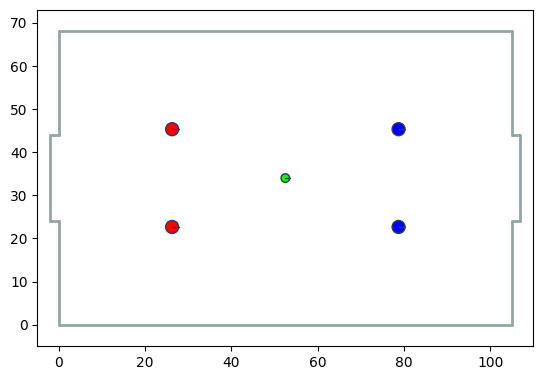

In [2]:
env = gym.make("Futbol2v2-v1")
env.render()

In [5]:
env.action_space

MultiDiscrete([5 5 5 5])

In [6]:
from stable_baselines3.common.env_checker import check_env
check_env(env)

# Learning model

In [2]:
log_dir = "logs/"
timesteps = 50000

In [3]:
from stable_baselines3.common.env_util import make_vec_env

env = gym.make("Futbol2v2-v1")
env = make_vec_env(lambda: env, n_envs=4, monitor_dir=log_dir)
model = A2C("MlpPolicy", env, device='cpu')
model.learn(timesteps)
model.save("models/footbol2v2-ppo")

# Display model statistic

     index            r   l          t
0        0   155.344302  75   0.836995
1        1    37.251805  75   1.236683
2        2   246.193750  75   1.547551
3        3 -1014.314991  75   1.856825
4        4   295.685775  75   2.164369
..     ...          ...  ..        ...
161    161  1597.695812  75  57.009118
162    162   -56.477502  75  57.346870
163    163  2567.793982  75  57.695286
164    164   363.661477  75  58.012881
165    165   113.101150  75  58.335833

[166 rows x 4 columns]


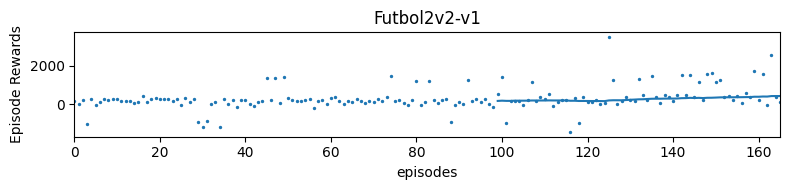

In [4]:
from IPython import display
from stable_baselines3.common import results_plotter

results_plotter.plot_results([log_dir], timesteps, results_plotter.X_EPISODES, "Futbol2v2-v1")
display.display(plt.gcf())
display.clear_output(wait=True)

log_data = results_plotter.load_results(log_dir)
print(log_data)

# Load model from file

In [12]:
model = A2C.load("models/footbol2v2-a2c", device="cpu")

# Run models

## Pygame
Run game with model in new windows with pygame

In [13]:
RES = WIDTH, HEIGHT = 600, 600
FPS = 60

env = gym.make("Futbol2v2-v1", width=WIDTH-2, height=HEIGHT-2, player_radius=15, ball_radius=5)
visualizer = utils.PygameVisualizer(env, FPS)
visualizer.run(model)

env.close()
visualizer.close()

## Matplotlib
Run model in notebook with matplotlib

KeyboardInterrupt: 

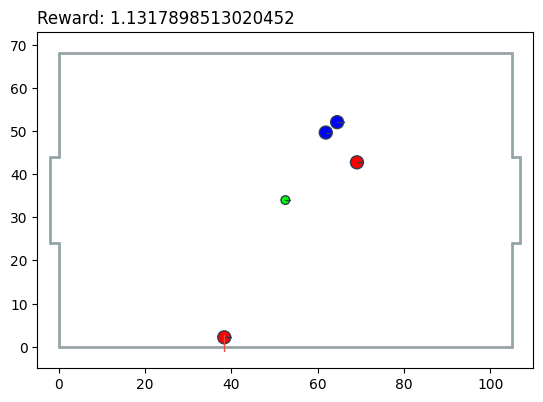

In [25]:
env = gym.make("Futbol2v2-v1")

visualizer = utils.MatplotlibVisualizer(env)
visualizer.run(model)

env.close()

# MultiAgent

## Learn

In [5]:
env = make_vec_env(lambda: gym.make("Futbol2v2-v1"), n_envs=1)

models = [
    MultiAgentOnPolicyProxy(A2C("MlpPolicy",
                             utils.TransformAction(env, lambda a: a[:2], gym.spaces.MultiDiscrete([5, 5])),
                             device='cpu')),
    MultiAgentOnPolicyProxy(A2C("MlpPolicy",
                             utils.TransformAction(env, lambda a: a[2:], gym.spaces.MultiDiscrete([5, 5])),
                             device='cpu'))
]

timesteps = 50000
n_records_count = models[0].model.n_steps
max_episode_reward = 0

### Rewrote learning cycle
StableBaselines3 не поддерживает одновременное обучение нескольких агентов, это даже не ошибка по мнению разработчиков. Они считают, что в данном случае каждому пользователю необходимо самостоятельо переопределить цикл обучения (для не мультиагентных задач используется метод learn). Здесь представлен код, взятый из исходных кодов StableBaselines3, но адаптированный для многоагентных задач.
В обычной ситуации, learn сам взаимодействует со средой. Но при существовании нескольких агентов нужно получить действие от каждого и только потом передавать их в среду. Именно это здесь и реализовано. Каждому агенту передается наблюдение от среды (в данной задаче оно одинаково для всех) и получается действие. Затем действия объеядиняются и передаются среде. Затем каждый агент обновляется с учетом полученных данных (метод record).
Весь код, взятый из StableBaselines3 вынесен в класс MultiAgentModelProxy.

In [6]:
#TODO: рассмотреть возможность асинхронной среды
#TODO: добавить вывод логов для последующего использования results_plotter

In [7]:
for model in models:
    model.start_learning(timesteps)

observation = env.reset()
total_reward = 0
max_step_reward = 0
time = 0
while time < timesteps:
    current_step_reward = 0

    for model in models:
        model.start_record()

    for step in range(n_records_count):
        actions = [model.predict(observation)[0] for model in models]
        total_action = np.concatenate(np.concatenate(actions))
        time += env.num_envs

        next_observation, reward, done, info = env.step(np.array([total_action]))
        total_reward += reward
        current_step_reward += reward

        for model, action in zip(models, actions):
            model.record(observation, action, next_observation, reward, done, info)

        observation = next_observation

    for model in models:
        model.end_record()
        model.train()

    print(time, current_step_reward)

    if current_step_reward > max_step_reward:
        max_step_reward = current_step_reward
        for index, model in enumerate(models):
            model.model.save(f"models/footbol2v2-a2c-best-{index}")

for index, model in enumerate(models):
            model.model.save(f"models/footbol2v2-a2c-last-{index}")

5 [6.364228]
10 [18.96548]
15 [29.135303]
20 [26.718594]
25 [31.902859]
30 [30.660675]
35 [22.95741]
40 [30.684612]
45 [29.215355]
50 [26.0808]
55 [5.215825]
60 [-0.9850695]
65 [-0.3355848]
70 [5.4854503]
75 [17.052485]
80 [13.335595]
85 [10.9859705]
90 [14.564562]
95 [21.968143]
100 [33.76663]
105 [34.272163]
110 [35.45925]
115 [35.68643]
120 [36.395]
125 [35.245457]
130 [38.80496]
135 [39.76073]
140 [31.797096]
145 [50.491882]
150 [33.8008]
155 [30.852352]
160 [32.952564]
165 [19.34344]
170 [9.773834]
175 [-18.796043]
180 [974.0285]
185 [7.532697]
190 [10.046859]
195 [19.44397]
200 [14.209641]
205 [6.9210653]
210 [12.296388]
215 [9.811226]
220 [12.100816]
225 [14.734169]
230 [12.806977]
235 [11.867009]
240 [3.3192673]
245 [-0.35601074]
250 [-6.8175616]
255 [-9.989985]
260 [-6.0414944]
265 [-11.083621]
270 [-15.2575035]
275 [-20.363924]
280 [-20.659155]
285 [-15.737211]
290 [-22.283573]
295 [-10.552209]
300 [-10.297089]
305 [8.471287]
310 [18.630444]
315 [24.312191]
320 [27.014824]
32

## Load and visualise

In [8]:
models = [A2C.load(f"models/footbol2v2-a2c-last-{index}", device="cpu") for index in range(2)]

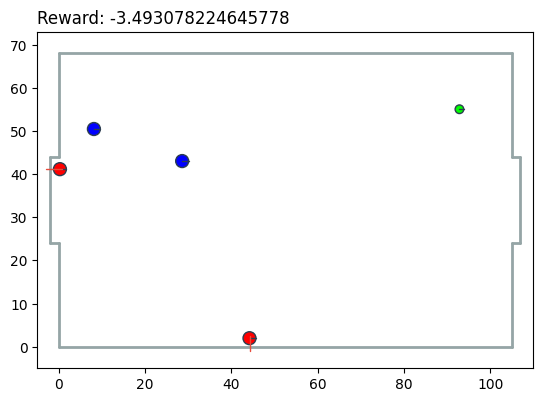

In [9]:
env = gym.make("Futbol2v2-v1")

multi_agent = utils.MultiModelAgent(models)

visualizer = utils.MatplotlibVisualizer(env)
visualizer.run(multi_agent)

env.close()